# Chapter 22: Semidefinite Programming in Action

One considers here the optimization program 
$$ \underset{f \in \mathcal{T}_n^{\rm even}}{\rm minimize} \; \|f^{(k)}\|_{L_p(\mathbb{T})}
\quad \mbox{subject to }
f(x^{(i)}) = y_i, \; i = 1,\ldots,m $$
Writing  $f \in \mathcal{T}_n^{\rm even}$ as $f = \sum_{j=0}^n a_j \cos(j \cdot)$, this program can be transformed into a semidefinite program involving $a\in\mathbb{R}^{n+1}$ in the cases $p=2$, $p=\infty$, and $p=1$. These cases are investigated below.

In [1]:
import numpy as np
from numpy import linalg as LA
import sympy
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# generate the data
m = 15
x = np.linspace(-np.pi,0,m)
y = x**2
# the matrix M used to express the equality constraints
n = 50
M = np.zeros((m,n+1))
for j in range(0,n+1):
    M[:,j] = np.cos(j*x)
# the grid necessary for plotting purposes
grid_size = 1000;
grid = np.linspace(-np.pi,np.pi,grid_size)

## The case $p=2$ 

When $p=2$, the optimization program is transformed (using the Schur complement) into the following semidefinite program:
$$ \underset{a \in \mathbb{R}^{n+1}, c\in \mathbb{R}}{\rm minimize} \; c
\quad \mbox{subject to }
Ma=y, \; \left[\matrix{c I_{n+1} & Da \cr (Da)^\top& c}\right] \succeq 0,$$
where $D \in \mathbb{R}^{(n+1) \times (n+1)}$ is the diagonal matrix $D = \sqrt{\pi} {\rm diag}[0;1;\ldots;n^k]$.

In [3]:
# solving the SDP
k = 2
D = np.sqrt(np.pi) * np.diag(np.arange(n+1)**k)
a_2 = cp.Variable((n+1,1))
c = cp.Variable((1,1))
objective = cp.Minimize(c)
constraints = [ M@a_2 == y.reshape((m,1)) ]
constraints+= [ cp.vstack( (cp.hstack((c*np.identity(n+1), D@a_2)),
                           cp.hstack(((D@a_2).T, c)))) >> 0 ]
L2 = cp.Problem(objective,constraints)
L2.solve()
a_2 = a_2.value

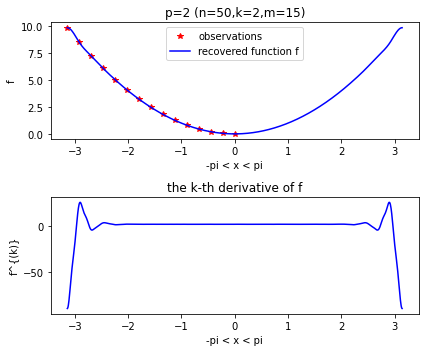

In [4]:
# visualizing the recovered function
f_2 = np.zeros(grid_size)
fk_2 = np.zeros(grid_size)
for j in range(n+1):
    f_2 = f_2 + a_2[j]*np.cos(j*grid)
    fk_2 = fk_2 - a_2[j]*j**k*np.cos(j*grid)     # to be modified for a different k
plt.figure(figsize=(6,5))
plt.subplot(2,1,1)
plt.plot(x,y,'r*',grid,f_2,'b-')
plt.legend(('observations','recovered function f'),loc='best')
plt.title('p=2 (n={},k={},m={})'.format(n,k,m))
plt.xlabel('{} < x < {}'.format(-sympy.pi,sympy.pi)) 
plt.ylabel('f')
plt.subplot(2,1,2)
plt.plot(grid,fk_2,'b-')
plt.title('the k-th derivative of f')
plt.xlabel('{} < x < {}'.format(-sympy.pi,sympy.pi)) 
plt.ylabel('f^{(k)}')
plt.tight_layout()
plt.show()

### An aside: verification of the closed-form expression given in Exercise 22.1.

In [5]:
Delta = np.diag(np.arange(1,n+1)**k)
A = M[:,1:] @ LA.inv(Delta)
A.shape
B = LA.inv(A@A.T)
a_sharp_0 = np.sum(y*np.sum(B,axis=1)) / np.sum(B)
a_sharp = np.hstack( (a_sharp_0, LA.inv(Delta) @ A.T @ B @ (y-a_sharp_0)) )
print('The solution of the SDP and the closed-form expression agree:\n the L2-distance between the coefficient vectors is {:.2e}'.
      format(LA.norm(a_2-a_sharp.reshape(a_2.shape))))

The solution of the SDP and the closed-form expression agree:
 the L2-distance between the coefficient vectors is 3.67e-07


## The case $p=\infty$

When $p=\infty$ and $k \equiv 2 ({\rm mod}\, 4)$, the optimization program is transformed (using the sum-of-squares technique) into the following semidefinite program:
$$ \underset{\matrix{a \in \mathbb{R}^{n+1},c \in \mathbb{R} \cr Q^+,Q^- \in \mathbb{C}^{(n+1) \times (n+1)}}}{\rm minimize} \, c
\qquad \mbox{subject to }
Ma = y, \; Q^{\pm } \succeq 0, \; \sum_i Q^{\pm}_{i,i}=c, \; \sum_{i-j=\ell} Q^{\pm}_{i,j} = \pm \frac{a_\ell \ell^k}{2} \mbox{ for }\ell =1,\ldots,n. $$

In [6]:
# solving the SDP
k = 2                    # as before
a_inf = cp.Variable(n+1)
c = cp.Variable(1)
Qp = cp.Variable((n+1,n+1),PSD=True)
Qm = cp.Variable((n+1,n+1),PSD=True)
objective = cp.Minimize(c)
constraints = [ M@a_inf == y ]
constraints += [cp.trace(Qp) == c]
constraints += [cp.trace(Qm) == c]
for l in range(1,n+1):
    A = np.diag(np.ones(n+1-l),l)
    constraints += [ cp.trace(A@Qp) ==  a_inf[l]*l**k/2 ]
    constraints += [ cp.trace(A@Qm) == -a_inf[l]*l**k/2 ]        # to be modified for a different k
L_inf = cp.Problem(objective,constraints)
L_inf.solve()
a_inf = a_inf.value

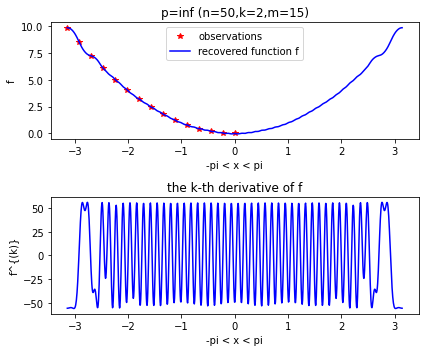

In [7]:
# visualizing the recovered function
f_inf = np.zeros(grid_size)
fk_inf = np.zeros(grid_size)
for j in range(n+1):
    f_inf = f_inf + a_inf[j]*np.cos(j*grid)
    fk_inf = fk_inf - a_inf[j]*j**k*np.cos(j*grid)        # to be modified for a different k
plt.figure(figsize=(6,5))
plt.subplot(2,1,1)    
plt.plot(x,y,'r*',grid,f_inf,'b-')
plt.legend(('observations','recovered function f'),loc='best')
plt.title('p=inf (n={},k={},m={})'.format(n,k,m))
plt.xlabel('{} < x < {}'.format(-sympy.pi,sympy.pi)) 
plt.ylabel('f')
plt.subplot(2,1,2)
plt.plot(grid,fk_inf,'b-')
plt.title('the k-th derivative of f')
plt.xlabel('{} < x < {}'.format(-sympy.pi,sympy.pi)) 
plt.ylabel('f^{(k)}')
plt.tight_layout()
plt.show()

## The case $p=1$

When $p=1$ and $k$ is even, the optimization program is approximated (using the method of moments) by the following semidefinite program:
$$ \underset{\matrix{a \in \mathbb{R}^{n+1}\cr u^+,u^- \in \mathbb{R}^{N+1}}}{\rm mininize}
(u^+_0 + u^-_0)
\quad \mbox{subject to }
Ma=y,\; {\rm Toep}_{N+1}(u^{\pm}) \succeq 0, \;
u^+ - u^- = \pi [0;a_1;a_2 2^k; \ldots; a_n n^k; 0 ; \ldots; 0], $$
where the truncation parameter $N\geq n$ is an integer chosen by the user (the bigger, the better, as long as the resulting SDP is solved efficiently and reliably).

In [8]:
# solving the SDP
k = 2            # as before
N = 90
a_1 = cp.Variable(n+1)
up = cp.Variable(N+1)
um = cp.Variable(N+1)
Up = cp.Variable((N+1,N+1),PSD=True)
Um = cp.Variable((N+1,N+1),PSD=True)
objective = cp.Minimize(up[0]+um[0])
constraints = [ M@a_1 == y ]
for i in range(N):
    for j in range(N):
        constraints += [ Up[i,j] == up[abs(i-j)] ]
        constraints += [ Um[i,j] == um[abs(i-j)] ]
constraints += [ up[j]-um[j] == np.pi*a_1[j]*j**k for j in range(n+1) ]
constraints += [ up[j]-um[j] == 0 for j in range(n+1,N+1) ]
L1 = cp.Problem(objective,constraints)
L1.solve()
a_1 = a_1.value

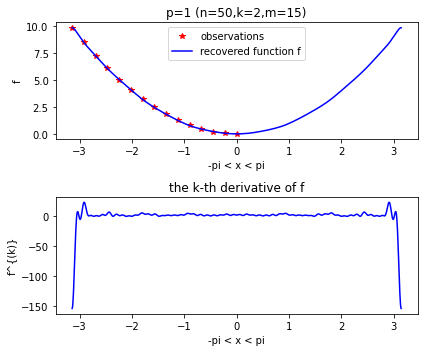

In [9]:
# plotting the recovered function
f_1 = np.zeros(grid_size)
fk_1 = np.zeros(grid_size)
for j in range(n+1):
    f_1 = f_1 + a_1[j]*np.cos(j*grid)
    fk_1 = fk_1 - a_1[j]*j**k*np.cos(j*grid)         # to be modified for a different k
plt.figure(figsize=(6,5))
plt.subplot(2,1,1)    
plt.plot(x,y,'r*',grid,f_1,'b-')
plt.legend(('observations','recovered function f'),loc='best')
plt.title('p=1 (n={},k={},m={})'.format(n,k,m))
plt.xlabel('{} < x < {}'.format(-sympy.pi,sympy.pi)) 
plt.ylabel('f')
plt.subplot(2,1,2)
plt.plot(grid,fk_1,'b-')
plt.title('the k-th derivative of f')
plt.xlabel('{} < x < {}'.format(-sympy.pi,sympy.pi)) 
plt.ylabel('f^{(k)}')
plt.tight_layout()
plt.show()